# Example: Build a Hidden Markov Model of Daily Stock Excess Growth Rate
This example will familiarize students with constructing an Observable Markov Model (OMM) of the excess growth rate of a ticker `XYZ` where we define the excess growth as:
$$
\begin{equation*}
R_{ij} \equiv \left(\frac{1}{\Delta{t}}\right)\cdot\ln\left(\frac{S_{i,j}}{S_{i,j-1}}\right) - \bar{r}_{f}
\end{equation*}
$$
where $R_{ij}$ denotes the excess growth rate of equity $i$ at time $j$, $\Delta{t}$ denotes the time-step between $j-1\rightarrow{j}$ (units: years), $S_{i,\star}$ denotes the share price of equity $i$ at time $\star$, and $\bar{r}_{f}$ denotes the annualized risk free rate. In this example, we build a model of daily return.

## Model
Describe the day-to-day variation of the excess growth using a fully observable Markov model $\mathcal{M}$ represented by the tuple $\mathcal{M} = (\mathcal{S},\mathcal{O},\mathbf{P},\mathbf{E})$; $\mathcal{S}$ is the set of hidden states, $\mathcal{O}$ is the set of observable states, $\mathbf{T}$ is the transition matrix, i.e., $t_{ij}\in\mathbf{T}$ is the probability of moving from hidden state $i$ to hidden state $j$ in the next time step, and $\mathbf{E}$ is the emission matrix. Because we are fully observable, the emission matrix $\mathbf{E} = \mathbf{I}$, where $\mathbf{I}$ is the identity matrix.

## Learning objectives
* __Task 1__: Construct the states $\mathcal{S}$, the emission matrix $\mathbf{E}$ and transition matrix $\hat{\mathbf{T}}$
    * `TODO`: Estimate the transition matrix $\hat{\mathbf{T}}$ from market data
* __Task 2__: Simulate the Hidden Markov Model (HMM) for an average trading year
    * `TODO`: Generate the stationary distribution from the estimated $\hat{\mathbf{T}}$ matrix
    * `TODO`: Implement the `MARKOV-SIMULATION` pseudo code from the lecture to generate hypothetical return sequences
* __Task 3__: Save the HMM model and other data to a file

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our lab problem.
* For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

In [3]:
include("Include.jl");

## Prerequisites: Load and clean the historical dataset
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2018` until `03-13-2024`, along with data for a few exchange-traded funds and volatility products during that time. In this block of code, we:
* Load and clean the historical data; store the cleaned data in the `dataset` variable. We then calculate the expected excess return $\mathbb{E}(R_{i})$ for each `ticker` in the `dataset.` Finally, you'll select a firm by changing the value in the `ticker` variable. We store the computed excess return for the `ticker` in the `Rᵢ` variable.

### Set parameters and constants

In [6]:
risk_free_rate = 0.0421; # 17-Jun-2024 10-year treasury
ticker = "SPY";

### Load and clean the historical data

We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) since `01-03-2018` until `03-13-2024`, along with data for a few exchange-traded funds and volatility products during that time. We load the `orignal_dataset` by calling the `MyPortfolioDataSet()` function:

In [9]:
original_dataset = MyPortfolioDataSet() |> x->x["dataset"];

Not all tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquisition or de-listing events. Let's collect only those tickers with the maximum number of traditional days. First, let's compute the number of records for a company that we know has a maximum value, e.g., `AAPL,` and save that value in the `maximum_number_trading_days` variable:

In [11]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow;

Then, iterate through our data and collect only tickers with `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [13]:
dataset = Dict{String,DataFrame}();
for (ticker,data) ∈ original_dataset
    if (nrow(data) == maximum_number_trading_days)
        dataset[ticker] = data;
    end
end

Lastly, let's get a sorted list of firms that we have in cleaned up `dataset` and save it in the `list_of_all_tickers` array

In [15]:
list_of_all_tickers = keys(dataset) |> collect |> x->sort(x);

We compute the expected (annualized) log growth rate by passing the `dataset` and the entire list of firms we have in the dataset (held in the $N\times{1}$ `all_array` array) to the [log_growth_matrix(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.log_growth_matrix). The result is stored in the `all_firms_return_matrix` variable, a $T-1\times{N}$ array of log return values. Each row of `all_firms_return_matrix` corresponds to a time value, while each column corresponds to a firm:

In [17]:
all_firms_excess_return_matrix = log_growth_matrix(dataset, list_of_all_tickers, 
    Δt = (1.0/252.0), risk_free_rate = risk_free_rate);

### Extract the growth rate for your `ticker`

In [19]:
Rᵢ = findfirst(x->x==ticker, list_of_all_tickers) |> i-> all_firms_excess_return_matrix[:,i];

## Task 1: Construct the states $\mathcal{S}$, the emission matrix $\mathbf{E}$ and transition matrix $\hat{\mathbf{T}}$
First, consider the states $\mathcal{S}$. Suppose we put a label (and number) the excess return values, ranging from `super bad = 1,` $\dots$,` unchanged,` $\dots$,` super good = N,` where if $R\ll{0}$, then we are in the `super bad = 1,` state or $R\gg{0}$ we are in the `super good = N` state (or we are someplace in between). 
* __Idea__: Use the [cumulative distribution function](https://en.wikipedia.org/wiki/Cumulative_distribution_function) computed from the observed return series $R_{i,1}, \dots, R_{i,n}$ to partition the actual (historical) excess returns into one of a fixed number of categories. Once we have the categories, compute the probability that category $i$ on the day $k$ is followed by category $j$ on the day $k+1$. These values are entries in the state transition matrix $\hat{\mathbf{T}}$.
* To start, specify a value for the  `number_of_states` variable, where the `number_of_states` controls how many categories we are using when splitting up the excess return time series. We then set the `states` vector, which holds the states (numbered from `1`$\rightarrow$`number_of_states`). 

In [21]:
number_of_states = 80; # TODO: specify a value here
states = range(1,stop=number_of_states) |> collect;

The `states` are hidden from the observer. Next, we set up the emissions matrix $\mathbf{E}$. For this example, because the states are __fully observable__, i.e., we can see the states directly,  the emission matrix $\mathbf{E}$ is the identity matrix $\mathbf{I}$:

In [23]:
E = diagm(ones(number_of_states));

### TODO: Estimate the transition matrix $\hat{\mathbf{T}}$ from market data
To estimate the transition matrix $\hat{\mathbf{T}}$, we'll estimate the transition probabilities from the excess return data calculated in the `Prerequisites` section and saved in the `Rᵢ` variable. 

In [25]:
in_sample_dataset = Rᵢ[1:(maximum_number_trading_days-1)] # set of excess return

1507-element Vector{Float64}:
  1.5129377454909538
  1.103368088086578
  0.7836592626051124
  0.7469204094703445
 -0.651317123297486
  1.2863386070568685
  1.8341837004768116
  0.5090457033442471
  0.6027732710078719
  0.45393924309987255
  0.46430928629127866
  1.7601322189385078
  1.0632224381234976
  ⋮
  2.473645326630101
  2.1846892155556126
 -1.3071088568715163
  1.300092524780104
  1.0882119750549104
 -1.2691490306414208
 -0.2817789495022863
  1.3302918641120702
  0.6544841382666371
  0.307245721134233
  0.48928417021417847
 -0.7889919650587696

Next, we need to model the return data distribution to compute the [cumulative distribution function](https://en.wikipedia.org/wiki/Cumulative_distribution_function). The excess return distribution is a random variable that follows some [probability distribution function](https://en.wikipedia.org/wiki/Probability_distribution). We don't know what that distribution function is, but for now, we assume the excess returns follow a [Laplace distribution](https://en.wikipedia.org/wiki/Laplace_distribution)
* We use the [fit_mle function](https://juliastats.org/Distributions.jl/stable/fit/#Distributions.fit_mle-Tuple{Any,%20Any}) exported by the [Distributions.jl package](https://github.com/JuliaStats/Distributions.jl) to fit a [Laplace distribution](https://en.wikipedia.org/wiki/Laplace_distribution) to our our data. We fit the distribution to the full dataset `Rₘ` and save the distribution in the `d` variable.

In [27]:
d = fit_mle(Laplace, Rᵢ); # use the *full* data set to establish the cutoff's

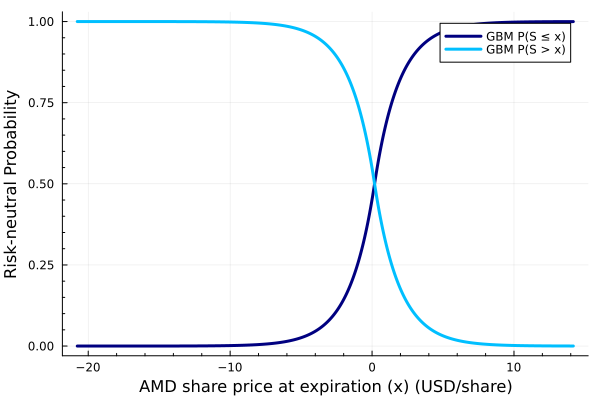

In [28]:
let

    # regions of return -
    number_of_samples = 1000;
    minimum_obs_growth = minimum(in_sample_dataset);
    maximum_obs_growth = maximum(in_sample_dataset);
    RA = range(minimum_obs_growth,stop = maximum_obs_growth, length = number_of_samples) |> collect;

    X = Array{Float64,2}(undef, number_of_samples,2);
    for i ∈ eachindex(RA)
    
        X[i,1] = RA[i];
        X[i,2] = cdf(d, RA[i]);
    end

    plot(X[:,1], X[:,2], lw=3, c=:navy, label="GBM P(S ≤ x)", xminorticks=5, yminorticks=5)
    plot!(X[:,1], 1 .- X[:,2], lw=3, c=:deepskyblue1, label="GBM P(S > x)")

    xlabel!("AMD share price at expiration (x) (USD/share)", fontsize=18);
    ylabel!("Risk-neutral Probability", fontsize=18);
end

Next, we generate the percentile cutoffs that we use to establish the bounds that correspond to each category of return, i.e., `super bad` or `super good`, etc.

In [30]:
percentage_cutoff = range(0.0,stop=1.0,length=(number_of_states+1)) |> collect;

Now that we have the cutoffs, compute the lower and upper bound for each potentiual category. To do this, we'll use the [quantile function](https://juliastats.org/Distributions.jl/stable/univariate/#Statistics.quantile-Tuple{UnivariateDistribution,%20Real}) exported by the [Distributions.jl package](https://github.com/JuliaStats/Distributions.jl). For a given `0 ≤ q ≤ 1`, `quantile(d, q)` is the smallest value `x` 
for which `cdf(d, x) ≥ q`.

In [32]:
bounds = Array{Float64,2}(undef, number_of_states, 3)
for s ∈ states
    bounds[s,1] = quantile(d,percentage_cutoff[s])
    bounds[s,2] = quantile(d,percentage_cutoff[s+1])
    bounds[s,3] = s
end
bounds

80×3 Matrix{Float64}:
 -Inf       -6.26173   1.0
  -6.26173  -5.05178   2.0
  -5.05178  -4.34401   3.0
  -4.34401  -3.84183   4.0
  -3.84183  -3.45232   5.0
  -3.45232  -3.13406   6.0
  -3.13406  -2.86498   7.0
  -2.86498  -2.63188   8.0
  -2.63188  -2.42628   9.0
  -2.42628  -2.24237  10.0
  -2.24237  -2.076    11.0
  -2.076    -1.92411  12.0
  -1.92411  -1.78439  13.0
   ⋮                  
   2.27916   2.43105  69.0
   2.43105   2.59742  70.0
   2.59742   2.78134  71.0
   2.78134   2.98694  72.0
   2.98694   3.22003  73.0
   3.22003   3.48911  74.0
   3.48911   3.80737  75.0
   3.80737   4.19688  76.0
   4.19688   4.69906  77.0
   4.69906   5.40683  78.0
   5.40683   6.61678  79.0
   6.61678  Inf       80.0

Now that we have the category bounds, let's take the excess return data and determine which state an excess return observation corresponds to. For each sample in the `in_sample_dataset`:
* Classify the sample value into one of the possible categories. Let `state = 1` equal the worst return, and `state = number_of_states` equal the best return. Save these results in the `encoded_in_sample` array:

In [34]:
encoded_in_sample = Array{Int64,1}();
for i ∈ eachindex(in_sample_dataset)
    value = in_sample_dataset[i];

    class_index = 1;
    for s ∈ states
        if (bounds[s,1] ≤ value && value < bounds[s,2])
            class_index = s;
            break;
        end
    end
    push!(encoded_in_sample, class_index);
end
encoded_in_sample;

In the matrix $\mathbf{T}$ compute the `counts` for transition from state `i` to state `j`:

In [36]:
T = zeros(number_of_states, number_of_states)
number_insample = length(encoded_in_sample);
for i ∈ 2:number_insample
    start_index = encoded_in_sample[i-1];
    stop_index = encoded_in_sample[i];
    T[start_index,stop_index] += 1;
end
T

80×80 Matrix{Float64}:
 3.0  1.0  2.0  0.0  1.0  1.0  2.0  0.0  …  1.0  1.0  0.0  0.0  0.0  0.0  2.0
 2.0  2.0  2.0  1.0  1.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 2.0  0.0  2.0  0.0  1.0  0.0  1.0  1.0     0.0  0.0  0.0  1.0  0.0  1.0  0.0
 1.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0     1.0  0.0  0.0  0.0  0.0  1.0  0.0
 2.0  0.0  2.0  1.0  0.0  0.0  1.0  0.0     0.0  1.0  0.0  0.0  1.0  0.0  1.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  …  0.0  1.0  0.0  0.0  0.0  0.0  2.0
 1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0     1.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  1.0  2.0  0.0  1.0  3.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0     0.0  1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0     0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  1.0  0.0  3.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  2.0  0.0     1.0  1.0  1.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  0.0  1.0  1.0  0.0  0.0  

From the `counts` matrix $\mathbf{T}$, compute the transtion probability matrix $\hat{\mathbf{T}}$:

In [38]:
T̂ = zeros(number_of_states, number_of_states)
for row ∈ states
    Z = sum(T[row,:]);
    for col ∈ states
        T̂[row,col] = (1/Z)*T[row,col]
    end
end
T̂

80×80 Matrix{Float64}:
 0.107143   0.0357143  0.0714286  …  0.0        0.0        0.0714286
 0.105263   0.105263   0.105263      0.0        0.0        0.0
 0.105263   0.0        0.105263      0.0        0.0526316  0.0
 0.0555556  0.0        0.0           0.0        0.0555556  0.0
 0.1        0.0        0.1           0.05       0.0        0.05
 0.05       0.0        0.0        …  0.0        0.0        0.1
 0.0588235  0.0588235  0.0588235     0.0        0.0        0.0
 0.0384615  0.0        0.0           0.0        0.0        0.0
 0.0        0.0666667  0.0666667     0.0        0.0        0.0
 0.0416667  0.0        0.0           0.0        0.0        0.0
 0.0        0.0666667  0.0        …  0.2        0.0        0.0
 0.0        0.0555556  0.0           0.0        0.0        0.0
 0.0625     0.0625     0.0625        0.0        0.0        0.0
 ⋮                                ⋱                        
 0.0        0.0        0.05          0.0        0.0        0.0
 0.0555556  0.0        0.0  

## Task 2: Simulate the Hidden Markov Model (HMM)
To do the simulation, we first build a [`MyHiddenMarkovModel` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/markov/#VLQuantitativeFinancePackage.MyHiddenMarkovModel), which holds the data for our Markov model. We use a [`build(...)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/markov/#VLQuantitativeFinancePackage.build-Tuple{Type{MyHiddenMarkovModel},%20NamedTuple}), which takes information about the `states,` the estimated transition matrix $\hat{\mathbf{T}}$, and the emission matrix $\mathbf{E}$ and returns a [`MyHiddenMarkovModel` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/markov/#VLQuantitativeFinancePackage.MyHiddenMarkovModel), which we save in the `model` variable.

In [40]:
model = build(MyHiddenMarkovModel, (
    states = states,
    T = T̂, 
    E = E
));

### TODO: Generate the stationary distribution from the estimated $\hat{\mathbf{T}}$ matrix
Generate the stationary distribution for the estimated transition matrix $\hat{\mathbf{T}}$ and use it to construct a [Categorical distribution](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Categorical) representing the stationary distrubution, save the [Categorical distribution](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Categorical) in the `π̄`-variable:

In [42]:
power_value = 50;
π̄ = (T̂^power_value) |> tmp -> Categorical(tmp[1,:]); # TODO: compute the stationary distribution (approx value is ok)

### TODO: Implement the `MARKOV-SIMULATION` pseudo code to generate hypothetical return sequences
Generate 'number_of_paths' example sequences, each containing 'number_of_steps' days. These variables determine the length and number of our hypothetical return sequences. Assume each path starts from a draw from the stationary distribution `π̄.`
* Save the simulated return sequences in the `archive::Array{Int64,2}(undef, number_of_steps, number_of_paths)` array, where the `row` index corresponds to a path, and the `col` index corresponds to a day.
* We have implemented some shortcut logic to speed up the implementation. To evaluate the Markov model for a `number_of_steps,` issue the command `model(start_state, number_of_steps).` This will compute a chain with `number_of_steps` starting as `start_state` and return the simulated sequence as an `array.` 

In [44]:
number_of_paths = 100;
number_of_steps = maximum_number_trading_days;
encoded_archive = Array{Int64,2}(undef, number_of_steps, number_of_paths);
for i ∈ 1:number_of_paths
    start_state = rand(π̄);
    tmp = model(start_state, number_of_steps)
    for j ∈ 1:number_of_steps
        encoded_archive[j,i] = tmp[j]
    end
end
encoded_archive

1508×100 Matrix{Int64}:
 28   4  22  39  59  53  38  30  29  …  23  29  43  46  21  80  75  14  13
  5   6  77  46  34  53  55   6  56     55  54  47  22  53  32  14  71  48
  1  17  41  19  26  29  44  80  36     44  65  64  46  77  29  25  44  12
  2   6  18  45  62  54  54   4  65     54  40  65  56  58   1  59  28  76
  2  33   9  56  50   1  21  58  47     78  29  58  53  32  80  72  17  67
  2  48  35  77  44   5  22  19  53  …  75  49  49  10   4  78  71  28  54
 73  54  53  53   5  39   8  51  77     68  24  50  76   1  48  65  47  40
 58  46  52  77  15  49  57  80  15     59  80   9  37   1  36  29  23  47
 19  36  74  41  71  61  71  32  12     51  70  64  48  80  57  49  41  64
 34  42  50   5  49   8  52  26  76     32  63  55  28  39  34  17  45  70
 24  67  35   1   8  28  49  19  21  …   4  40  14  46  64  62  52  62  55
 73  77  22   7  26  59  45  21  23      9  54   8  29  36  62  33  44  69
 11  13   8  15  50  79   9  16  45     16   1  61  54  58  52  35  62   6
 

In [45]:
actual_sample_bounds = copy(bounds);
actual_sample_bounds[1,1] = minimum(in_sample_dataset);
actual_sample_bounds[end,2] = maximum(in_sample_dataset)
actual_sample_bounds

80×3 Matrix{Float64}:
 -20.7722   -6.26173   1.0
  -6.26173  -5.05178   2.0
  -5.05178  -4.34401   3.0
  -4.34401  -3.84183   4.0
  -3.84183  -3.45232   5.0
  -3.45232  -3.13406   6.0
  -3.13406  -2.86498   7.0
  -2.86498  -2.63188   8.0
  -2.63188  -2.42628   9.0
  -2.42628  -2.24237  10.0
  -2.24237  -2.076    11.0
  -2.076    -1.92411  12.0
  -1.92411  -1.78439  13.0
   ⋮                  
   2.27916   2.43105  69.0
   2.43105   2.59742  70.0
   2.59742   2.78134  71.0
   2.78134   2.98694  72.0
   2.98694   3.22003  73.0
   3.22003   3.48911  74.0
   3.48911   3.80737  75.0
   3.80737   4.19688  76.0
   4.19688   4.69906  77.0
   4.69906   5.40683  78.0
   5.40683   6.61678  79.0
   6.61678  14.1804   80.0

### Decode operation
To turn the state $s\in\mathcal{S}$ back into an excess return value, we need to __decode__ the state. To do this, let's construct a [Normal distribution](https://en.wikipedia.org/wiki/Normal_distribution) describing the observed return values associated with each state in the `encoded_in_sample` dataset.
* We collect the observed excess return samples associated with a particular state $s$, store them in a `tmp` array, and use [Maximum Likelihood Estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) to estimate a [Normal distribution exported from the Distributions.jl package](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Normal)

In [47]:
decode_distribution_model = Dict{Int,Normal}()
for s ∈ states

    # what indexes correspond to state s
    index_collection_state_s = findall(x-> x == s, encoded_in_sample);
    tmp = Array{Float64,1}();
    for i ∈ index_collection_state_s
        decoded_value = Rᵢ[i];
        push!(tmp, decoded_value);
    end
    decode_distribution_model[s] = fit_mle(Normal,tmp);
end
decode_distribution_model;

Then, generate a random value for the excess return by sampling the appropriate [Normal distribution](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Normal). We develop `number_of_paths` trajectories, each containing `number_of_steps` values. We store these values in the `decoded_archive` variable:

In [49]:
in_sample_decoded_archive = Array{Float64,2}(undef, number_of_steps, number_of_paths);
for i ∈ 1:number_of_paths
    for j ∈ 1:number_of_steps
        s = encoded_archive[j,i];
        in_sample_decoded_archive[j,i] =  decode_distribution_model[s] |> d -> rand(d)
    end
end
in_sample_decoded_archive # actual excess growth value

1508×100 Matrix{Float64}:
  -0.457983  -3.93559    -0.91479    …   3.66609   -1.69421   -1.8232
  -3.89384   -3.22545     4.44736       -1.73634    2.66339    0.558632
 -12.0741    -1.35117     0.203192      -0.680001   0.331564  -1.98299
  -5.63536   -3.28073    -1.31459        1.26276   -0.46964    4.04998
  -6.41454   -0.1956     -2.49284        2.89085   -1.38544    2.09642
  -5.39509    0.531989   -0.0795891  …   2.79861   -0.505801   0.870199
   3.10539    0.889936    0.847796       1.89732    0.48831    0.145382
   1.18455    0.419296    0.741605      -0.440058  -0.789963   0.468739
  -1.1413    -0.0406054   3.25096        0.594215   0.218133   1.69341
  -0.117462   0.266084    0.651001      -1.38969    0.378171   2.54301
  -0.758077   2.10829    -0.106848   …   0.762119   1.51893    0.953497
   3.07957    4.56667    -0.899016      -0.220363   0.297391   2.35977
  -2.2814    -1.83332    -2.82999       -0.085247   1.50368   -3.17687
   ⋮                                 ⋱         

### Visualize an example in-sample return trajectory
`Unhide` the code block to see how we plotted the observed (red) and simulated (blue) excess growth rate values for a randomly selected sample model generated sample path.

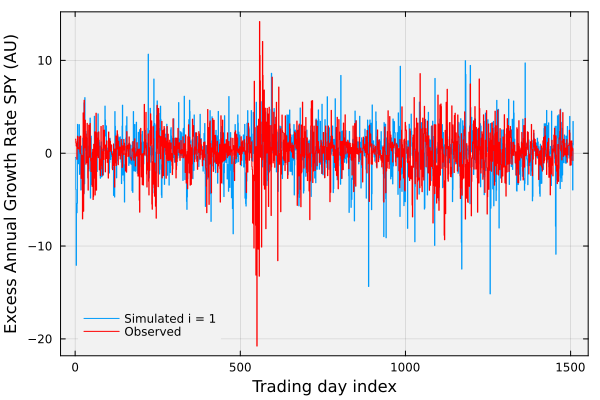

In [51]:
let
    index_to_plot = rand(1:number_of_paths);
    plot(in_sample_decoded_archive[:,index_to_plot], linetype=:steppost, label="Simulated i = $(index_to_plot)", 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent)
    plot!(in_sample_dataset, linetype=:steppost, c=:red, label="Observed")
    xlabel!("Trading day index", fintsize=18)
    ylabel!("Excess Annual Growth Rate $(ticker) (AU)", fontsize=18)
end

`Unhide` the code block below to see how we plotted the observed and simulated excess annual growth rate distribution for the in-sample data.

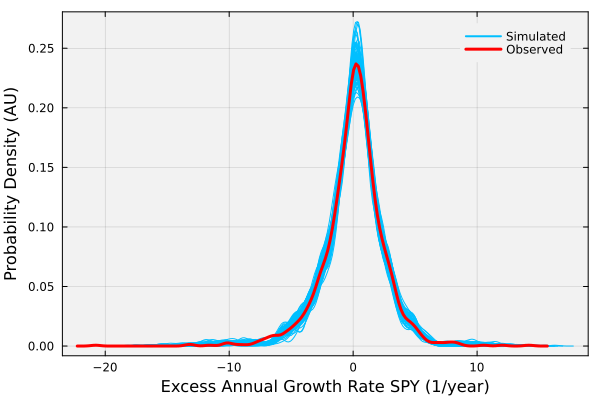

In [53]:
let
    q = plot(); 
    density!(in_sample_decoded_archive[:,1], lw=2, c=:deepskyblue1, label="Simulated", 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent)
    for i ∈ 2:number_of_paths
        density!(in_sample_decoded_archive[:,i], lw=1, c=:deepskyblue1, label="")
    end
    density!(in_sample_dataset, c=:red, lw=3, label="Observed")
    xlabel!("Excess Annual Growth Rate $(ticker) (1/year)", fontsize=18)
    ylabel!("Probability Density (AU)", fontsize=18)
    current()
end

### Check: Are the predicted and observed in-sample distributions the same? 
If our Markov model is correct, then the observed excess growth rate distribution and the excess growth distribution calculated by our model should look like they are drawn from the same distribution. To check this hypothesis, use [the ApproximateTwoSampleKSTest exported by the HypothesisTests.jl package](https://github.com/JuliaStats/HypothesisTests.jl) with the hypotheses:
* `H0:null hypothesis` is that `x` and `y` are drawn from the same distribution against the `H1:alternative hypothesis` that `x` and `y` come from different distributions.

Let's run [the ApproximateTwoSampleKSTest function](https://github.com/JuliaStats/HypothesisTests.jl) on a single (randomly selected) example trajectory to see what happens (most of the time, we fail to reject `H0`, i.e., the test suggests `x` and `y` are from the same distribution): 

In [55]:
ApproximateTwoSampleKSTest(in_sample_dataset,in_sample_decoded_archive[:,rand(1:number_of_paths)])

Approximate two sample Kolmogorov-Smirnov test
----------------------------------------------
Population details:
    parameter of interest:   Supremum of CDF differences
    value under h_0:         0.0
    point estimate:          0.0321132

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.4186

Details:
    number of observations:   [1507,1508]
    KS-statistic:              0.8816515045041413


However, we have `number_of_paths` example trajectories (not just one), so let's do the same test on each sample and compute an overall expected score. Specify a `pvalue_cutoff` value to check against. If the test returns `pvalue > pvalue_cutoff,` then we fail to reject `H0:null hypothesis`, i.e., `x` and `y` appear to be drawn from the same distribution.

In [57]:
let
    pvalue_cutoff = 0.05; # 95% cutoff
    pass_counter = 0;
    for i ∈ 1:number_of_paths
        test_value = ApproximateTwoSampleKSTest(in_sample_dataset,in_sample_decoded_archive[:,i]) |> pvalue
        if (test_value > pvalue_cutoff)
            pass_counter += 1 # we pass (fail to reject) x and y are from the same distribution
        end
    end
    println("Pass percentage: $((pass_counter/number_of_paths)*100)%")
end

Pass percentage: 98.0%


## Task 4: What does our Jump model do?

In [59]:
jump_model = let
    
    model = build(MyHiddenMarkovModelWithJumps, (
        states = states,
        T = T̂, 
        E = E,
        ϵ = 0.0001,
        λ = 63,
    ));

    model;
end;

In [60]:
encoded_archive_with_jumps = let
    number_of_paths = 100;
    encoded_archive = Array{Int64,2}(undef, number_of_steps, number_of_paths);
    for i ∈ 1:number_of_paths
        start_state = rand(π̄);

        @show i
        
        tmp = jump_model(start_state, number_of_steps)
        for j ∈ 1:number_of_steps
            encoded_archive[j,i] = tmp[j]
        end
    end
    encoded_archive
end

i = 1
number_of_jumps = 43
i = 2
i = 3
i = 4
i = 5
i = 6
i = 7
i = 8
i = 9
i = 10
i = 11
number_of_jumps = 60
i = 12
i = 13
i = 14
number_of_jumps = 64
i = 15
i = 16
i = 17
i = 18
i = 19
i = 20
i = 21
i = 22
i = 23
i = 24
i = 25
i = 26
i = 27
i = 28
i = 29
number_of_jumps = 63
i = 30
number_of_jumps = 59
i = 31
i = 32
i = 33
i = 34
i = 35
i = 36
i = 37
i = 38
i = 39
number_of_jumps = 57
i = 40
i = 41
i = 42
i = 43
i = 44
i = 45
i = 46
i = 47
number_of_jumps = 69
i = 48
i = 49
i = 50
number_of_jumps = 70
i = 51
i = 52
i = 53
i = 54
i = 55
number_of_jumps = 66
i = 56
number_of_jumps = 81
i = 57
i = 58
i = 59
i = 60
i = 61
i = 62
i = 63
number_of_jumps = 46
i = 64
i = 65
i = 66
i = 67
i = 68
i = 69
number_of_jumps = 54
i = 70
i = 71
i = 72
number_of_jumps = 68
i = 73
i = 74
number_of_jumps = 81
i = 75
i = 76
i = 77
i = 78
number_of_jumps = 51
i = 79
i = 80
i = 81
i = 82
i = 83
i = 84
i = 85
i = 86
number_of_jumps = 60
i = 87
i = 88
i = 89
number_of_jumps = 54
i = 90
i = 91
i = 92
i = 93
i

1508×100 Matrix{Int64}:
 67  57  19  10  77  59  71  57  40  …  67  74   7  48  14  58  28  24   1
 77  28  21  10  36  21  78  33  36      5  74  16  61  75  24  32  20  12
 15  17  22  76  18  23  27  40  58     39  74  61  65  48   2  12  24  65
 71  45  68  37   9  21  19  41  34     49  31  12  33  14   3  24  44  43
 73   8   5   7  64  63  34   5  53     53  37   7  12  71  11  15  31  53
  2  69   1   3  55  38  65  62  52  …  49  37  70  56  65  76   3  51  77
 73  26  12   7  74  48  24  55  24     53   8  50   4  20  69   5  51   4
 70  50  56   2  50  74  61  73   2     38   8  47  52  13  67  75  44  74
 71  13   2  11  46  31  65  68  22     24  61  46  22  26  25  45  31  63
 49  26  22  63  47  44  47  32  68     43  33  56  71  69  59  70  48  69
 68  10  68   8  46  25  53  22  22  …  17  67   2  44  45  21  54  54   6
 62  14  56  33  39  71  49  50  36     15   6  27  28  68  63  40  15  30
 41   1  24  63  14  12  56  43  13     17  55  74  32  46   9  27  72   3
 

In [61]:
in_sample_decoded_archive_with_jumps = let
    in_sample_decoded_archive = Array{Float64,2}(undef, number_of_steps, number_of_paths);
    for i ∈ 1:number_of_paths
        for j ∈ 1:number_of_steps
            s = encoded_archive_with_jumps[j,i];
            in_sample_decoded_archive[j,i] =  decode_distribution_model[s] |> d -> rand(d)
        end
    end
    in_sample_decoded_archive # actual excess growth value
end;

In [62]:
in_sample_decoded_archive_with_jumps

1508×100 Matrix{Float64}:
  2.06043      1.13203    -1.19073   …  -0.450095   -0.758264  -8.36132
  4.24356     -0.453872   -0.943377     -0.250525   -1.09282   -1.94936
 -1.56196     -1.33824    -0.910067     -2.00832    -0.728998   1.80062
  2.76064      0.383143    2.18778      -0.768846    0.323788   0.293664
  3.13755     -2.62161    -3.95875      -1.57662    -0.287639   0.859531
 -5.5218       2.34808    -9.87456   …  -4.68193     0.7031     4.54354
  3.08171     -0.630814   -2.01339      -3.69639     0.73168   -4.23778
  2.45893      0.643236    1.01935       3.67906     0.335417   3.22372
  2.69012     -1.8676     -5.60097       0.391522   -0.306359   1.64304
  0.589474    -0.606132   -0.8549        2.43735     0.542646   2.34417
  2.20313     -2.35642     2.18163   …   0.901709    0.882909  -3.33506
  1.52459     -1.6698      1.04276       0.116021   -1.60485   -0.364604
  0.191159   -11.0942     -0.73104      -0.525023    2.93799   -4.81454
  ⋮                                

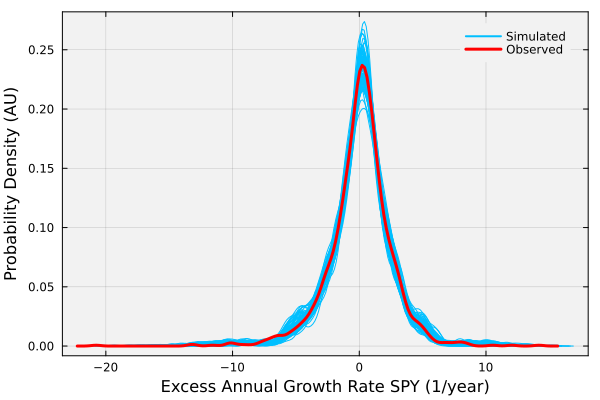

In [63]:
let
    q = plot(); 
    density!(in_sample_decoded_archive_with_jumps[:,1], lw=2, c=:deepskyblue1, label="Simulated", 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent)
    for i ∈ 2:number_of_paths
        density!(in_sample_decoded_archive_with_jumps[:,i], lw=1, c=:deepskyblue1, label="")
    end
    density!(in_sample_dataset, c=:red, lw=3, label="Observed")
    xlabel!("Excess Annual Growth Rate $(ticker) (1/year)", fontsize=18)
    ylabel!("Probability Density (AU)", fontsize=18)
    current()
end

In [64]:
let
    pvalue_cutoff = 0.05; # 95% cutoff
    pass_counter = 0;
    for i ∈ 1:number_of_paths
        test_value = ApproximateTwoSampleKSTest(in_sample_dataset,in_sample_decoded_archive_with_jumps[:,i]) |> pvalue
        if (test_value > pvalue_cutoff)
            pass_counter += 1 # we pass (fail to reject) x and y are from the same distribution
        end
    end
    println("Pass percentage: $((pass_counter/number_of_paths)*100)%")
end

Pass percentage: 98.0%


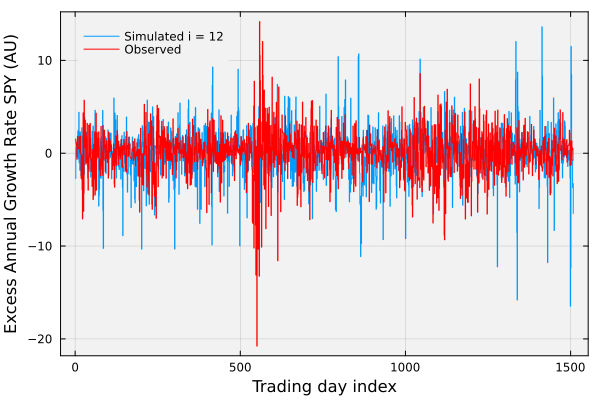

In [65]:
let
    index_to_plot = rand(1:number_of_paths);
    index_to_plot = 12;
    plot(in_sample_decoded_archive_with_jumps[:,index_to_plot], linetype=:steppost, label="Simulated i = $(index_to_plot)", 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent)
    plot!(in_sample_dataset[1:(number_of_steps-1)], linetype=:steppost, c=:red, label="Observed")
    xlabel!("Trading day index", fintsize=18)
    ylabel!("Excess Annual Growth Rate $(ticker) (AU)", fontsize=18)
end

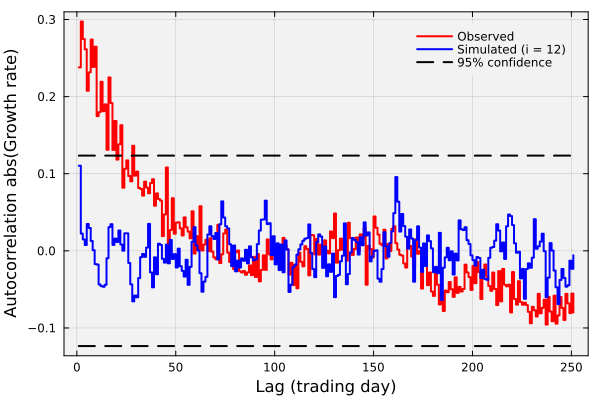

In [66]:
let
    # generate a random index -
    random_index = rand(1:number_of_paths);
    number_of_steps = 252;
    random_index = 12

    
    plot(autocor(abs.(in_sample_dataset), (2:number_of_steps |> collect)), label="Observed", lw=2, c=:red, 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent, linetype=:steppost)
    plot!(autocor(abs.(in_sample_decoded_archive_with_jumps[:,random_index]), ((2:number_of_steps) |> collect)), c=:blue, lw=2,
        label="Simulated (i = $(random_index))", linetype=:steppost)
    
    LINE = (1.96/sqrt(number_of_steps))*ones(number_of_steps-1);
    plot!(LINE, label="95% confidence", lw=2, c=:black, ls=:dash)
    plot!(-LINE, label="", lw=2, c=:black, ls=:dash)
    xlabel!("Lag (trading day)", fontsize=18)
    ylabel!("Autocorrelation abs(Growth rate)", fontsize=18)
end

### Task 4: Save the HMM model and other data to a file
In the project for this module, we'll use the hidden Markov Model (HMM) we developed here. Let's save the model to disk to save some time later on. Use the [save(...) method exported by the JLD2.jl package](https://github.com/JuliaIO/JLD2.jl.git) to write a [model file in HDF5 binary format](https://en.wikipedia.org/wiki/Hierarchical_Data_Format). First, we specify a `path` in the `path_to_save_file` variable: 

In [68]:
path_to_save_file = joinpath(_PATH_TO_DATA,"HMM-WJ-$(ticker)-daily-aggregate.jld2");

Then we write an [`HDF5 binary file`](https://en.wikipedia.org/wiki/Hierarchical_Data_Format) holding our data to the location specified by `path_to_save_file.` We use the [save(...) function exported by the JLD2.jl package to write a binary save file](https://github.com/JuliaIO/JLD2.jl.git) (later we'll use to the `load(...)` function to reload this data):

In [70]:
save(path_to_save_file, Dict("model"=>model, "jump_model" => jump_model,
        "decode"=>decode_distribution_model, "stationary"=>π̄, 
        "insampledataset"=>in_sample_dataset, "encoded_archive" => encoded_archive, "encoded_archive_with_jumps" => encoded_archive_with_jumps,
        "in_sample_decoded_archive_with_jumps" => in_sample_decoded_archive_with_jumps, 
        "in_sample_decoded_archive" => in_sample_decoded_archive));

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. You should decide solely based on your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.